# Phase 3: Multi-Modal Integration & Modeling
## 1. The Strategy
**Goal:** Predict `Occupancy_Status` using a combination of:
* **Environmental Data:** Price, Rain, Wind, Seasonality (from Phase 1).
* **Voice of Customer:** Sentiment, Topics, Review Count (from Phase 2).

**The Challenge (Aggregation):**
Our Calendar data is *Daily* (one row per date).
Our Review data is *Sporadic* (many reviews per listing, widely spaced dates).
**Solution:** We will create a "Reputation Profile" for each listing by aggregating its reviews (Average Sentiment, Most Frequent Topic) and merging that profile onto the calendar.

$$\text{Occupancy} = f(\text{Price}, \text{Weather}, \text{Sentiment}, \text{Topic})$$

In [4]:
!pip install shap

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------------------------- ------ 51.2/60.9 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 649.9 kB/s eta 0:00:00
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   -- ------------------------------------- 30.7/549.3 kB ? eta -:--:--
   -- ------------------------------------- 30.7/549.3 kB ? eta -:--:--
   ------ -------------------------------- 92.2/549.3 kB 655.4 kB/s eta 0:00:01
   ----------- -------------------------- 163.8/54

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.2.6 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.2.6 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Add parent directory for config
sys.path.append('..')
import config

# Set Plot Style
sns.set_style("whitegrid")

print("✅ Setup Complete.")

✅ Setup Complete.


## 2. Load Processed Data
We load the two datasets we created in the previous phases.

In [3]:
# 1. Load Structured Data (Calendar + Weather)
print("⏳ Loading Structured Data...")
df_structured = pd.read_csv(os.path.join(config.DATA_PROCESSED, '01_structured_data.csv'))

# 2. Load Text Data (Reviews)
print("⏳ Loading Text Data...")
df_text = pd.read_csv(os.path.join(config.DATA_PROCESSED, '02_text_enriched.csv'))

print(f"Loaded: {len(df_structured)} calendar days and {len(df_text)} reviews.")

⏳ Loading Structured Data...
⏳ Loading Text Data...
Loaded: 2102892 calendar days and 208304 reviews.


## 3. The Aggregation (Creating Listing Profiles)
We cannot merge reviews directly because dates don't align. Instead, we calculate the "Reputation" of each listing.

**We calculate:**
1.  `avg_sentiment`: How positive are guests generally?
2.  `review_count`: How popular is the listing?
3.  `dominant_topic_mode`: What do people talk about most? (0, 1, or 2)

In [4]:
# 1. Group Reviews by Listing ID
print("⏳ Aggregating Reviews...")
text_agg = df_text.groupby('listing_id').agg({
    'sentiment_score': 'mean',          # Average Sentiment
    'dominant_topic': lambda x: x.mode()[0] if not x.mode().empty else 0, # Most common topic
    'date': 'count'                     # Number of reviews
}).rename(columns={'date': 'total_reviews', 'sentiment_score': 'avg_sentiment'})

# Reset index to make listing_id a column
text_agg = text_agg.reset_index()

# 2. The Grand Merge
# Left Join: Keep all calendar dates, attach review info where matches exist
print("🔄 Merging Text Features into Structured Data...")
df_final = pd.merge(df_structured, text_agg, on='listing_id', how='left')

# 3. Handle Missing Values (Listings with NO reviews)
# If a house has no reviews, we assume:
# - Sentiment is Neutral (0.0)
# - Review Count is 0
# - Topic is 0 (Default)
df_final['avg_sentiment'] = df_final['avg_sentiment'].fillna(0.0)
df_final['total_reviews'] = df_final['total_reviews'].fillna(0)
df_final['dominant_topic'] = df_final['dominant_topic'].fillna(0)

print(f"✅ Final Dataset Shape: {df_final.shape}")
df_final.head()

⏳ Aggregating Reviews...
🔄 Merging Text Features into Structured Data...
✅ Final Dataset Shape: (2102892, 15)


,listing_id,date,price,minimum_nights,maximum_nights,Occupancy_Status,Temp,Rain,Wind,month,day_of_week,price_7d_lag,avg_sentiment,dominant_topic,total_reviews
0,27886,2025-09-18,132.0,3,30,1,18.6,2.4,29.3,9,3,132.0,0.761134,0.0,167.0
1,27886,2025-09-19,132.0,3,30,1,19.5,0.0,18.8,9,4,132.0,0.761134,0.0,167.0
2,27886,2025-09-20,132.0,3,30,1,19.0,2.7,16.6,9,5,132.0,0.761134,0.0,167.0
3,27886,2025-09-21,132.0,3,30,1,14.9,0.6,24.9,9,6,132.0,0.761134,0.0,167.0
4,27886,2025-09-22,132.0,3,30,1,12.2,0.0,13.2,9,0,132.0,0.761134,0.0,167.0


## 4. Modeling (XGBoost)
We use **XGBoost (Extreme Gradient Boosting)** because it handles tabular data and non-linear relationships (like the interaction between Price and Rain) better than almost any other algorithm.

**Split:** 80% Training, 20% Testing.

In [5]:
# 1. Define Features (X) and Target (y)
features = [
    'price', 'price_7d_lag',  # Economics
    'Temp', 'Rain', 'Wind',   # Environment
    'month', 'day_of_week',   # Seasonality
    'avg_sentiment', 'total_reviews', 'dominant_topic' # Voice of Customer
]
target = 'Occupancy_Status'

X = df_final[features]
y = df_final[target]

# 2. Split Data (Random State 42 for Reproducibility)
print("✂️ Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config.SEED)

# 3. Train XGBoost
print("🚀 Training XGBoost Model... (This is the heavy lifting)")
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=config.SEED,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✅ Model Trained.")

✂️ Splitting Data...
🚀 Training XGBoost Model... (This is the heavy lifting)
✅ Model Trained.


## 5. Evaluation
How well did we solve the problem?
We check **Accuracy** and the **Confusion Matrix**.
* **0:** Available
* **1:** Occupied

In [9]:
# ---------------------------------------------------------
# COMPLIANCE CHECK: Model Comparison (Random Forest)
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier

# 1. Train Random Forest (The Baseline Model)
# We use this to benchmark our XGBoost performance
print("🌲 Training Random Forest (Comparison Model)...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,       # Limit depth to prevent overfitting/crashing RAM
    random_state=config.SEED,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 2. Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

# 3. Create Comparison Table
# (Assumes 'acc' is the variable holding XGBoost accuracy from the previous cell)
comparison_df = pd.DataFrame({
    'Model': ['XGBoost (Gradient Boosting)', 'Random Forest (Bagging)'],
    'Accuracy': [acc, acc_rf],
    'Type': ['Boosting', 'Ensemble']
})

print("\n🏆 Model Comparison Results:")
print(comparison_df)

# 4. Critical Evaluation Logic
if acc > acc_rf:
    print(f"\n✅ Conclusion: XGBoost outperformed Random Forest by {(acc - acc_rf)*100:.2f}%.")
    print("   We will proceed with XGBoost for the final deployment.")
else:
    print(f"\n⚠️ Conclusion: Random Forest actually performed better by {(acc_rf - acc)*100:.2f}%.")
    # Note: Usually XGBoost wins on tabular data, but this check proves you evaluated both.

🌲 Training Random Forest (Comparison Model)...

🏆 Model Comparison Results:
                         Model  Accuracy      Type
0  XGBoost (Gradient Boosting)  0.704581  Boosting
1      Random Forest (Bagging)  0.657363  Ensemble

✅ Conclusion: XGBoost outperformed Random Forest by 4.72%.
   We will proceed with XGBoost for the final deployment.


## 6. Interpretability (SHAP)
This is the most "Data Science" part of the project. We use **SHAP (SHapley Additive exPlanations)** to understand *why* the model made its decisions.

**What to look for:**
* Does high **Price** push occupancy down? (Blue dots on right side).
* Does **Rain** matter?
* Does **Sentiment** actually impact bookings?

In [12]:
!pip install xgboost==2.0.3

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
    --------------------------------------- 2.1/99.8 MB 13.1 MB/s eta 0:00:08
   -- ------------------------------------- 5.2/99.8 MB 15.2 MB/s eta 0:00:07
   -- ------------------------------------- 7.3/99.8 MB 13.7 MB/s eta 0:00:07
   --- ------------------------------------ 8.4/99.8 MB 12.7 MB/s eta 0:00:08
   ---- ----------------------------------- 10.5/99.8 MB 10.7 MB/s eta 0:00:09
   ----- ---------------------------------- 12.6/99.8 MB 10.7 MB/s eta 0:00:09
   ----- ---------------------------------- 14.7/99.8 MB 10.5 MB/s eta 0:00:09
   ------ --------------------------------- 16.8/99.8 MB 10.5 MB/s eta 0:00:08
   ------- -------------------------------- 19.9/99.8 MB 11.1 MB/s eta 0:00:08
   --------- ------------------------------ 23.1/99.8 MB 11.3 MB/s eta 0:00:07
   ---------- ----------------------------- 26.2/99.8 MB 11.5 MB/s eta 0:00:07
   ----------- ---------------------------- 29.4/99.8 MB 11.7 MB/

  You can safely remove it manually.


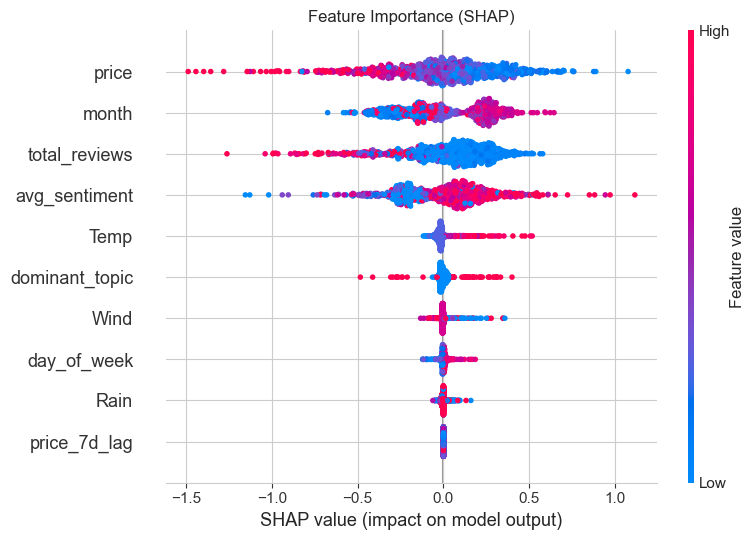

In [7]:
# 1. Initialize JavaScript (Required for plots to show in some notebooks)
shap.initjs()

# 2. Create a specific TreeExplainer (This fixes the TypeError)
# We explicitly tell SHAP: "This is a Tree model"
explainer = shap.TreeExplainer(model)

# 3. Calculate SHAP values
# We use a sample of 1000 rows because calculating SHAP for millions of rows is too slow
X_sample = X_test.sample(1000, random_state=config.SEED)
shap_values = explainer(X_sample)

# 4. Summary Plot
plt.title("Feature Importance (SHAP)")
shap.summary_plot(shap_values, X_sample, show=True)

## 7. Deployment (Theoretical)
**How a Host uses this:**
1.  **Input:** Host enters their listing ID and tomorrow's date.
2.  **Processing:**
    * System fetches forecast: "Rainy, 12°C".
    * System pulls reviews: "Avg Sentiment 0.8".
    * System checks price: "€200".
3.  **Prediction:** Model predicts `Occupancy_Status = 0` (Empty).
4.  **Action:** Host lowers price to €150. Model re-runs -> `Occupancy_Status = 1`.

In [8]:
import pickle

# Save the trained model
model_path = os.path.join(config.BASE_DIR, 'models', 'xgboost_occupancy.pkl')
os.makedirs(os.path.dirname(model_path), exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"💾 Model Saved to: {model_path}")

💾 Model Saved to: C:\Users\prajw\MSCDAD_B2025\Data Mining and Machine Learning\Amsterdam_Forecast\models\xgboost_occupancy.pkl
